In [198]:
from ase.io import read
from ase.units import create_units, Ry, kB, Bohr
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.build import make_supercell

In [230]:
units = create_units("2014")
bar = units["bar"]
eV = units["eV"]
GPa = units["GPa"]

**Effect of k-points**

Text(0, 0.5, 'Energy (Ry)')

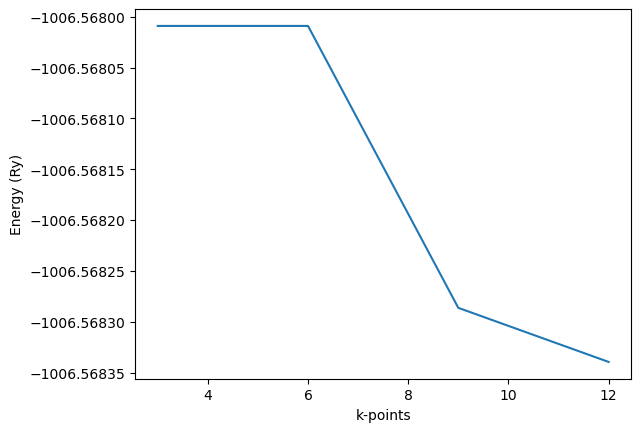

In [200]:
k3_file = "./hexagonal/ZnO_mp-2133_hexagonal-k3.out"
k6_file = "./hexagonal/ZnO_mp-2133_hexagonal-k6.out"
k9_file = "./hexagonal/ZnO_mp-2133_hexagonal-k9.out"
k12_file = "./hexagonal/ZnO_mp-2133_hexagonal-1.00.out"

ZnO_cub_k3 = read(k6_file, format="espresso-out")
ZnO_cub_k6 = read(k6_file, format="espresso-out")
ZnO_cub_k9 = read(k9_file, format="espresso-out")
ZnO_cub_k12 = read(k12_file, format="espresso-out")

k_list = [3,6,9,12]
energy_list = [ZnO_cub_k3.get_total_energy()/Ry,
               ZnO_cub_k6.get_total_energy()/Ry, 
               ZnO_cub_k9.get_total_energy()/Ry, 
               ZnO_cub_k12.get_total_energy()/Ry]

plt.plot(k_list, energy_list)
plt.ticklabel_format(useOffset=False)
plt.xlabel("k-points")
plt.ylabel("Energy (Ry)")

**Effect of cut-off energy**

Text(0, 0.5, 'Energy (Ry)')

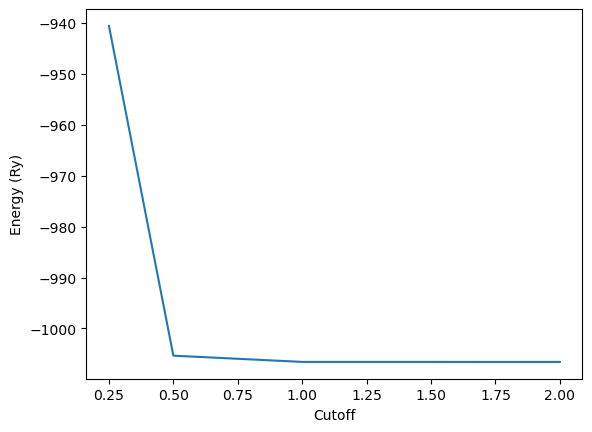

In [201]:
ZnO_hex_200co = read("./hexagonal/ZnO_mp-2133_hexagonal-co2.out", format="espresso-out")
ZnO_hex_100co = read("./hexagonal/ZnO_mp-2133_hexagonal-1.00.out", format="espresso-out")
ZnO_hex_50co = read("./hexagonal/ZnO_mp-2133_hexagonal-co0.5.out", format="espresso-out")
ZnO_hex_25co = read("./hexagonal/ZnO_mp-2133_hexagonal-co0.25.out", format="espresso-out")

cutoff_list = [0.25, 0.5, 1, 2]
energy_list = [ZnO_hex_25co.get_total_energy()/Ry, 
               ZnO_hex_50co.get_total_energy()/Ry, 
               ZnO_hex_100co.get_total_energy()/Ry, 
               ZnO_hex_200co.get_total_energy()/Ry]

plt.plot(cutoff_list, energy_list)
plt.ticklabel_format(useOffset=False)
plt.xlabel("Cutoff")
plt.ylabel("Energy (Ry)")

**Calculate bulk modulus**

In [202]:
#write cubic bulk bulk modulus txt file and show E V diagram
volume_list = []
energy_list = []
stress_list = []
amplifier = np.arange(0.90, 1.10, 0.02)
for amp in amplifier:
    amp = "{:.2f}".format(amp)                                      #keep format to be the same
    filename = "./hexagonal/ZnO_mp-2133_hexagonal-" + str(amp) + ".out"
    ZnO_hex = read(filename)
    volume_list.append(ZnO_hex.get_volume())                        #unit A^3
    energy_list.append(ZnO_hex.get_total_energy()/Ry)               #unit Ry
    stress_list.append(np.trace((ZnO_hex.get_stress(voigt=False) / bar) / 1000)/3)    #unit kbar

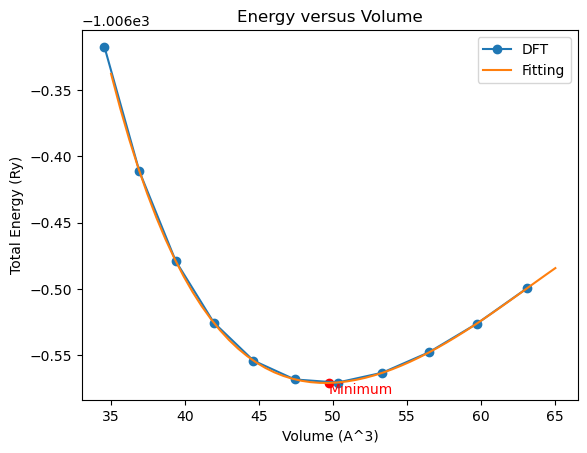

Minimum energy lattice constant: 3.2888194 A
Accuracy of prediction: 0.9841016967821543


In [203]:
#plot energy volume curve
coef = np.polyfit(volume_list, energy_list, 5)
f = np.poly1d(coef)
volume_fit = np.linspace(35, 65, 50)
energy_fit = f(volume_fit)
energy_min_index = np.argmin(energy_fit)

plt.plot(volume_list, energy_list, marker='o')
plt.plot(volume_fit, energy_fit)
plt.scatter(volume_fit[energy_min_index], energy_fit[energy_min_index], color='red')
plt.annotate("Minimum", (volume_fit[energy_min_index], energy_fit[energy_min_index]), color = "red", va = "top")
plt.xlabel("Volume (A^3)")
plt.ylabel("Total Energy (Ry)")
plt.legend(["DFT", "Fitting"])
plt.title("Energy versus Volume")
plt.show()

V = volume_fit[energy_min_index]
V0 = np.dot([0, 0, 5.2220613], np.cross([3.23735102, 0, 0], [-1.61867551, 2.8036282243, 0]))
m = (V/V0)**(1/3)
accuracy = 1 - abs(1 - m)/1
print("Minimum energy lattice constant:", "{:.7f}".format(m*3.23735102), "A")
print("Accuracy of prediction:", accuracy)

In [204]:
m*5.2220613

5.305083213969578

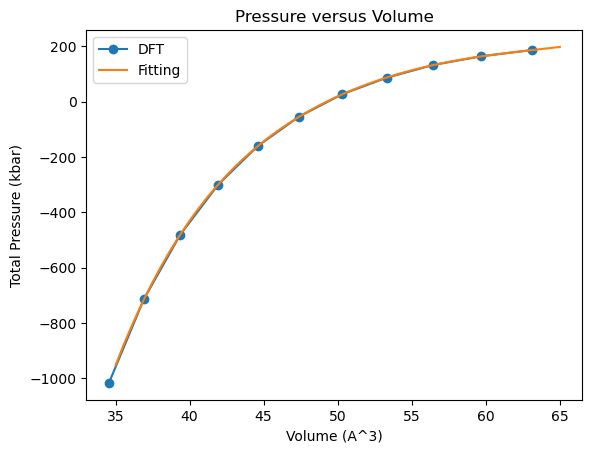

In [205]:
coef = np.polyfit(volume_list, stress_list, 5)
f = np.poly1d(coef)
dp_dv = f.deriv()
volume_fit = np.linspace(35, 65, 50)
stress_fit = f(volume_fit)

plt.plot(volume_list, stress_list, marker='o')
plt.plot(volume_fit, stress_fit)
plt.ticklabel_format(useOffset=False)
plt.xlabel("Volume (A^3)")
plt.ylabel("Total Pressure (kbar)")
plt.legend(["DFT", "Fitting"])
plt.title("Pressure versus Volume")
plt.show()

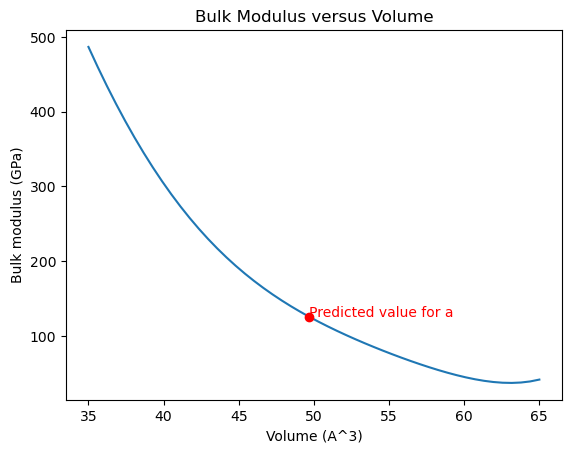

Predicted stress at a0: 125.71515834210064 GPa
Accuracy of prediction: 0.9821496745476612


In [206]:
#plot bulk modulus volume curve
stress_fit = dp_dv(volume_fit)*volume_fit / 10 #GPa
stress_mp_predict = dp_dv(V)*(V) / 10 #GPa
stress_mp = 128 #GPa

plt.plot(volume_fit, stress_fit)
plt.plot(V, stress_mp_predict, 'ro')
plt.annotate("Predicted value for a", (V, stress_mp_predict), color = "red")
plt.xlabel("Volume (A^3)")
plt.ylabel("Bulk modulus (GPa)")
plt.title("Bulk Modulus versus Volume")
plt.show()

accuracy = 1 - abs(stress_mp - stress_mp_predict) / stress_mp
print("Predicted stress at a0:", stress_mp_predict, "GPa")
print("Accuracy of prediction:", accuracy)

**Caculate shear modulus**

In [233]:
ZnO = read("./hexagonal/ZnO_mp-2133_hexagonal-1.00.out")
ZnO_xy = read("./hexagonal/ZnO_mp-2133_hexagonal-0.01xyshear.out")
ZnO_xz = read("./hexagonal/ZnO_mp-2133_hexagonal-0.01xzshear.out")
ZnO_yz = read("./hexagonal/ZnO_mp-2133_hexagonal-0.01yzshear.out")

In [234]:
s_xy = ZnO_xy.get_stress()[5] / GPa
s_xz = ZnO_xz.get_stress()[4] / GPa
s_yz = ZnO_yz.get_stress()[3] / GPa

In [235]:
print("Shear modulus in xy direction:", s_xy / 0.01, "GPa")
print("Shear modulus in xz direction:", s_xz / 0.01, "GPa")
print("Shear modulus in yz direction:", s_yz / 0.01, "GPa")

Shear modulus in xy direction: 179.45347065775655 GPa
Shear modulus in xz direction: 107.10719893918564 GPa
Shear modulus in yz direction: 107.09248843253283 GPa


**Calculate oxygen vacancy formation energy**

In [210]:
oxygen = read("./single_atom/oxygen.out")
oxygen_energy = oxygen.get_total_energy()

In [211]:
#1*1*1 cell
ZnO_hex_complete = read("./hexagonal/ZnO_mp-2133_111hexagonal_complete.out")
ZnO_hex_vacant = read("./hexagonal/ZnO_mp-2133_111hexagonal_vacant.out")

complete_energy = ZnO_hex_complete.get_total_energy()    #unit eV
vacant_energy = ZnO_hex_vacant.get_total_energy()  #unit eV

complete_atom = ZnO_hex_complete.get_global_number_of_atoms()

O_vf_energy = vacant_energy - complete_energy + oxygen_energy

print("Oxygen vacancy energy:", O_vf_energy)

Oxygen vacancy energy: 8.196250728411314


**Hydrogen absorption energy**

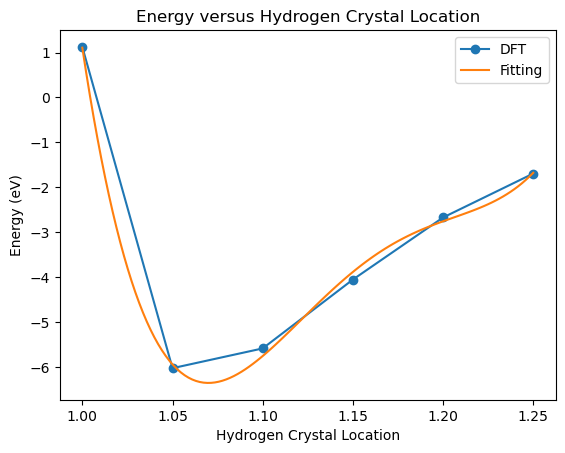

Hydrogen crystal location with minimum energy: 1.069327731092437
Hydrogen absorption energy: -6.356508467491949


In [212]:
H = read("./single_atom/hydrogen.out")
ZnO0 = read("./hexagonal/ZnOH_mp-2133_hexagonal-film.out")
ZnOH_100 = read("./hexagonal/ZnOH_mp-2133_hexagonal-1top.out")
ZnOH_105 = read("./hexagonal/ZnOH_mp-2133_hexagonal-1.05top.out")
ZnOH_110 = read("./hexagonal/ZnOH_mp-2133_hexagonal-1.1top.out")
ZnOH_115 = read("./hexagonal/ZnOH_mp-2133_hexagonal-1.15top.out")
ZnOH_120 = read("./hexagonal/ZnOH_mp-2133_hexagonal-1.2top.out")
ZnOH_125 = read("./hexagonal/ZnOH_mp-2133_hexagonal-1.25top.out")

energy = [
    ZnOH_100.get_total_energy() - ZnO0.get_total_energy() - H.get_total_energy(),
    ZnOH_105.get_total_energy() - ZnO0.get_total_energy() - H.get_total_energy(),
    ZnOH_110.get_total_energy() - ZnO0.get_total_energy() - H.get_total_energy(),
    ZnOH_115.get_total_energy() - ZnO0.get_total_energy() - H.get_total_energy(),
    ZnOH_120.get_total_energy() - ZnO0.get_total_energy() - H.get_total_energy(),
    ZnOH_125.get_total_energy() - ZnO0.get_total_energy() - H.get_total_energy(),
]

distance = [1, 1.05, 1.1, 1.15, 1.2, 1.25]
    
coef = np.polyfit(distance, energy, 4)
f = np.poly1d(coef)
x_fit = np.linspace(1.00, 1.25, 120)
y_fit = f(x_fit)

plt.plot(distance, energy, marker = "o")
plt.plot(x_fit, y_fit)
plt.xlabel("Hydrogen Crystal Location")
plt.ylabel("Energy (eV)")
plt.title("Energy versus Hydrogen Crystal Location")
plt.legend(["DFT", "Fitting"])
plt.show()

energy_min_index = np.argmin(y_fit)
location_min = x_fit[energy_min_index]
print("Hydrogen crystal location with minimum energy:", location_min)
print("Hydrogen absorption energy:", min(y_fit))